In [1]:
import talib
import pandas as pd

def find_high_low(df):
    '''
    Output:
    ------------
    (high_points, low_points)\n
    high_points = [{'high_date': '2019-01-01', 'high_price': 10.0}, ...]\n
    low_points = [{'low_date': '2019-01-01', 'low_price': 10.0}, ...]

    Example:
    ------------
    >>> df = pd.read_csv('000001.SZ.csv')
    >>> df['TRADE_DT'] = pd.to_datetime(df['TRADE_DT'], format='%Y%m%d')
    >>> df = df[['TRADE_DT', 'S_DQ_CLOSE']]
    >>> high_points, low_points = find_high_low(df)
    '''
    # 找出MACD
    macd, macd_signal, _ = talib.MACD(df['S_DQ_CLOSE'].values)
    df['macd'] = macd
    df['macd_signal'] = macd_signal

    # 找出金叉和死叉
    df['golden_cross'] = ((df['macd'] > df['macd_signal']) & (
        df['macd'].shift() < df['macd_signal'].shift())).astype(int)
    df['death_cross'] = ((df['macd'] < df['macd_signal']) & (
        df['macd'].shift() > df['macd_signal'].shift())).astype(int)

    # 选出金叉和死叉
    # * df_cross保存了金叉、死叉，shift_date是下一个x的日期
    df_cross = df[(df['golden_cross'] == 1) | (df['death_cross'] == 1)].copy()
    df_cross['shift_date'] = df_cross['TRADE_DT'].shift(-1)
    df_cross = df_cross.dropna(subset=['shift_date'])
    df_high_points = pd.DataFrame()
    df_low_points = pd.DataFrame()
    for index, row in df_cross.iterrows():
        # df3保存了两个x之间的df
        df_current_window = df[(df['TRADE_DT'] >= row['TRADE_DT']) & (
            df['TRADE_DT'] <= row['shift_date'])]
        if df_current_window.iloc[0]['golden_cross'] == 1:
            # * 金叉->死叉，之间是高点
            df_temp = df_current_window[df_current_window['S_DQ_CLOSE'].values ==
                                        df_current_window['S_DQ_CLOSE'].max()]
            df_temp = df_temp.head(1)
            df_high_points = pd.concat([df_high_points, df_temp])
        elif df_current_window.iloc[0]['death_cross'] == 1:
            # * 死叉->金叉，之间是低点
            df_temp = df_current_window[df_current_window['S_DQ_CLOSE'].values ==
                                        df_current_window['S_DQ_CLOSE'].min()]
            df_temp = df_temp.head(1)
            df_low_points = pd.concat([df_low_points, df_temp])

    # 初始化一个列表：high_points，其中每个元素是一个字典，包含两个键值对：high_date和high_price
    high_points = []
    for index, row in df_high_points.iterrows():
        high_points.append(
            {'high_date': row['TRADE_DT'], 'high_price': row['S_DQ_CLOSE']})
    # 初始化一个列表：low_points，其中每个元素是一个字典，包含两个键值对：low_date和low_price
    low_points = []
    for index, row in df_low_points.iterrows():
        low_points.append(
            {'low_date': row['TRADE_DT'], 'low_price': row['S_DQ_CLOSE']})

    return (high_points, low_points)

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
data = pd.read_csv('000001.SZ.csv')
df = pd.DataFrame(data)
# 转换日期列为日期时间类型
df['TRADE_DT'] = pd.to_datetime(df['TRADE_DT'], format='%Y%m%d')
# 按日期排序
df.sort_values('TRADE_DT', inplace=True)

In [3]:
hl = find_high_low(df)
#合并高低点
high_points_df = pd.DataFrame(hl[0])
high_points_df.insert(loc=2, column='state', value=1)
high_points_df.columns = ['date', 'price', 'state']
low_points_df = pd.DataFrame(hl[1])
low_points_df.insert(loc=2, column='state', value=-1)
low_points_df.columns = ['date', 'price', 'state']
points_df = pd.concat([high_points_df, low_points_df])
points_df.sort_values(by='date' , inplace=True, ascending=True)
points_df = points_df.reset_index(drop=True)

In [4]:
# 通过振幅选定横盘，选择参数为+-5%
sideways_all = []
for i in range(len(points_df)):
    if points_df['state'][i] == 1:
        min_price = 0.95 * points_df['price'][i]
        end_date = df[(df['TRADE_DT'] >= points_df['date'][i]) & (
            df['S_DQ_CLOSE'] < min_price)]['TRADE_DT'].min() - timedelta(days=1)
        start_date = df[(df['TRADE_DT'] <= points_df['date'][i]) & (
            df['S_DQ_CLOSE'] < min_price)]['TRADE_DT'].max() + timedelta(days=1)
        interval = (end_date - start_date).days
        price_median = np.median(df[(df['TRADE_DT'] >= start_date) & (
            df['TRADE_DT'] <= end_date)]['S_DQ_CLOSE'])
        sideways_all.append({'start_date': start_date, 'end_date': end_date,
                            'interval': interval, 'state': points_df['state'][i], 'median': price_median})
    else:
        max_price = 1.05 * points_df['price'][i]
        end_date = df[(df['TRADE_DT'] >= points_df['date'][i]) & (
            df['S_DQ_CLOSE'] > max_price)]['TRADE_DT'].min() - timedelta(days=1)
        start_date = df[(df['TRADE_DT'] <= points_df['date'][i]) & (
            df['S_DQ_CLOSE'] > max_price)]['TRADE_DT'].max() + timedelta(days=1)
        interval = (end_date - start_date).days
        price_median = np.median(df[(df['TRADE_DT'] >= start_date) & (
            df['TRADE_DT'] <= end_date)]['S_DQ_CLOSE'])
        sideways_all.append({'start_date': start_date, 'end_date': end_date,
                            'interval': interval, 'state': points_df['state'][i], 'median': price_median})


/Users/kai/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kai/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [5]:
sideways_all = pd.DataFrame(sideways_all)

In [6]:
sideways_all

,start_date,end_date,interval,state,median
0,2000-02-16,2000-03-08,21.0,-1,18.485
1,2000-03-09,2000-03-09,0.0,1,20.080
2,2000-03-14,2000-04-06,23.0,-1,18.460
3,2000-01-27,2000-05-14,108.0,1,18.585
4,2000-03-14,2000-04-11,28.0,-1,18.480
...,...,...,...,...,...
425,2023-02-18,2023-03-07,17.0,1,14.035
426,2023-03-10,2023-05-07,58.0,-1,12.680
427,2022-11-29,2023-04-23,145.0,1,13.230
428,2023-04-21,2023-05-03,12.0,-1,12.270


In [7]:
sideways_all['amplitude'] = 0.0
for i in range(len(sideways_all)):
    if i > 0:
        amplitude = abs(sideways_all['median'][i] - sideways_all['median'][i-1]) / sideways_all['median'][i]
        sideways_all['amplitude'][i] = amplitude
    else:
        sideways_all['amplitude'][i] = 0.0

/var/folders/f9/b51s7zb522gdcv9fkbfxx33c0000gn/T/ipykernel_95209/2684703752.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sideways_all['amplitude'][i] = 0.0
/var/folders/f9/b51s7zb522gdcv9fkbfxx33c0000gn/T/ipykernel_95209/2684703752.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sideways_all['amplitude'][i] = amplitude


In [8]:
#删除振幅过小的部分
amplitude_all = sideways_all[sideways_all['amplitude']>0.05]

{'whiskers': [<matplotlib.lines.Line2D at 0x7fbfe9b32610>,
 'caps': [<matplotlib.lines.Line2D at 0x7fbfe9b32d30>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fbfe9b32280>],
 'medians': [<matplotlib.lines.Line2D at 0x7fbfe9b3b4c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fbfe9b3b850>],
 'means': []}

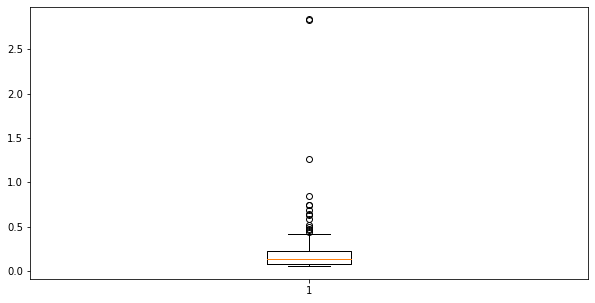

In [12]:
plt.boxplot(amplitude_all['amplitude'])

2023-02-10 00:00:00
2023-02-19 00:00:00
9.0
---
2023-03-10 00:00:00
2023-05-07 00:00:00
58.0
---
2023-04-21 00:00:00
2023-05-03 00:00:00
12.0
---


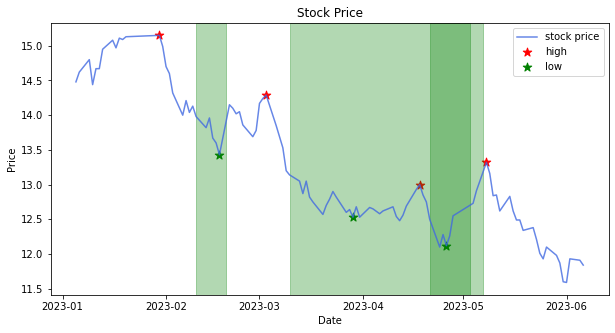

(277, 26988.0)

In [11]:
import horizontal_area as ha
ha.draw_horizontal_area(df, amplitude_all, hl[0], hl[1], '000001.SZ.csv')